In [37]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio 
from rasterio.plot import show
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline
sns.set()

In [89]:
#inputs
intiff = Path(r"D:\jlogan\2018-676-FA\wildlands_dl\wildlands\ortho\2018-10-23-Wildlands_ortho.tif")
inveght = Path(r"D:\jlogan\2018-676-FA\wildlands_dl\wildlands\shp\vegheightpoints_1m_mean.shp")

outdir = Path(r"D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw")
chipsize = 128  #pixels

outdir.mkdir(parents=True, exist_ok=True)

In [23]:
#load raster
dataset = rasterio.open(intiff)
aff = dataset.transform

#load shape
veghtdf = gpd.read_file(inveght)

In [90]:
veghtdf['col'], veghtdf['row'] = ~aff * (veghtdf.geometry.x, veghtdf.geometry.y)
veghtdf['col_int'] = np.floor(veghtdf['col']).astype(int)
veghtdf['row_int'] = np.floor(veghtdf['row']).astype(int)

In [157]:
#show(dataset.read())

In [29]:
img = dataset.read()

In [8]:
img.shape

(3, 43008, 30720)

In [92]:
#bin gridcode by 0.25
mincode = np.floor(veghtdf['grid_code'].min()*4)/4
maxcode = np.ceil(veghtdf['grid_code'].max()*4)/4
#bins = np.arange(mincode,maxcode+0.25, 0.25)
#labels = [str(x) for x in bins[:-1]]
bins = np.arange(mincode,maxcode+0.25, 0.25)
labels = ['VegHt' + str(int(x*-100)) + 'cm' for x in bins[:-1]]
veghtdf['binned'] = pd.cut(veghtdf['grid_code'], bins=bins, labels=labels)



In [93]:
veghtdf.loc[6]

OBJECTID                                               7
pointid                                                7
grid_code                                        -0.5055
geometry     POINT (615979.4000000013 4243921.500000002)
binned                                         VegHt75cm
col                                              10262.5
row                                              3453.12
col_int                                            10262
row_int                                             3453
Name: 6, dtype: object

In [32]:
def crop(a, row, col, sz):
    startrow = int(row - ((sz/2)-1))
    startcol = int(col - ((sz/2)-1))
    b = a[:,startrow:startrow+sz,startcol:startcol+sz]
    return b   

In [95]:
n = 0
for row in veghtdf.itertuples():
    #crop image
    cropped = crop(img, row.row_int, row.col_int, chipsize)
    
    #make output dir if doesn't exist
    labeloutdir = outdir.joinpath(outdir,row.binned)
    labeloutdir.mkdir(parents=True, exist_ok=True)
    
    #transpose so ch,row,col becomes row,col,ch for PIL
    im = Image.fromarray(cropped.transpose(1,2,0)).convert('RGB')
    
    #namestr = 'img' + str(row.grid_code) + '_' + str(round(row.geometry.x)) + '_' + str(round(row.geometry.y)) + '_' + str(n) + '.jpg'
    #namestr = 'img_' + '{:.3f}'.format(row.grid_code) + '_' + '{:05d}'.format(row.pointid) + '.jpg'
    namestr = 'img_' + str(int((row.grid_code)*-100)) + 'cm_' + '{:05d}'.format(row.pointid) + '.jpg'
    print(f'Writing {namestr} to {labeloutdir}...')
    im.save(labeloutdir.joinpath(namestr))
    n+=1

Writing img_25cm_00001.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt50cm...
Writing img_74cm_00002.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt75cm...
Writing img_108cm_00003.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt125cm...
Writing img_7cm_00004.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt25cm...
Writing img_20cm_00005.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt25cm...
Writing img_27cm_00006.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt50cm...
Writing img_50cm_00007.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt75cm...
Writing img_32cm_00008.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt50cm...
Writing img_20cm_00009.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\VegHt25cm...
Writing img_14cm_00010.jpg to D:\jlogan\2018-676-FA\wildlands_dl\wildlands\dltrain2\raw\Ve

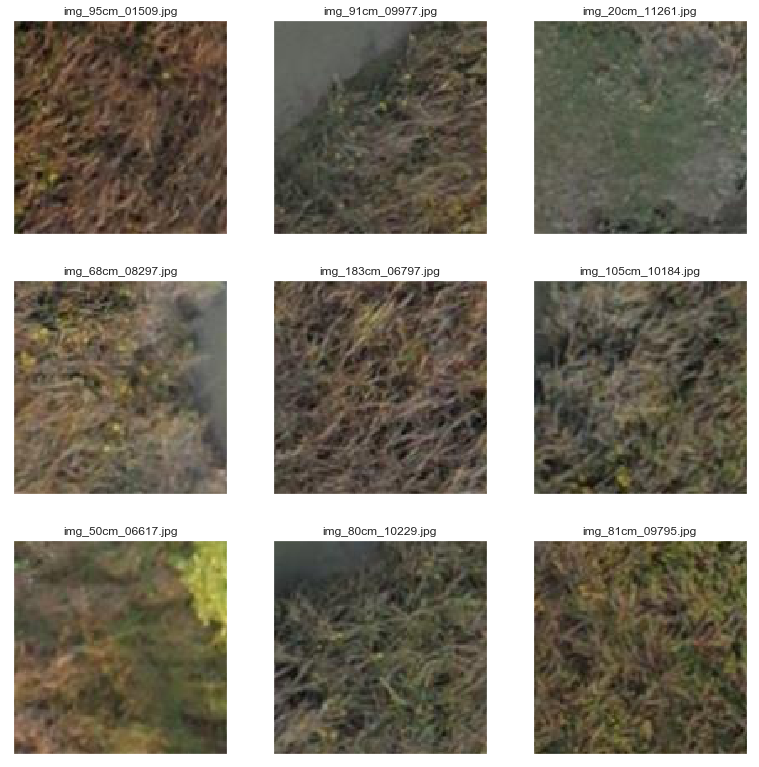

In [96]:
#plot random rgb images
fig, axs = plt.subplots(figsize=(11,11), ncols=3, nrows=3)
files = random.sample([f for f in outdir.glob('**/*.jpg')],15)
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    im = Image.open(files[i])
    ax.imshow(im)
    ax.grid(False)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.set_title(files[i].name)

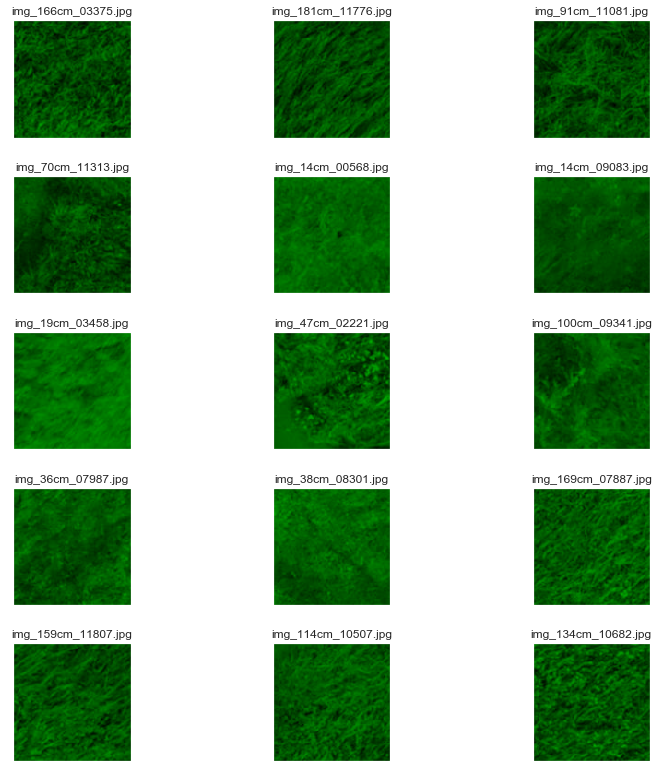

In [97]:
#plot random single band images
def channel(img, n):
    """Isolate the nth channel from the image.

       n = 0: red, 1: green, 2: blue
    """
    a = np.array(img)
    a[:,:,(n!=0, n!=1, n!=2)] *= 0
    return Image.fromarray(a)

fig, axs = plt.subplots(figsize=(11,11), ncols=3, nrows=5)
files = random.sample([f for f in outdir.glob('**/*.jpg')],15)
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    im = Image.open(files[i])
    ch = channel(im,1)
    ax.imshow(ch)
    ax.grid(False)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.set_title(files[i].name)